In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import cv2

from torch.utils.data import Dataset, DataLoader

import torch.nn.functional as F

In [2]:
def generate_circle_dataset(n_samples=1000, height=128, width=128, radius_range=(10, 30)):
    imgs = np.zeros((n_samples, height, width), dtype=np.uint8)
    masks = np.zeros((n_samples, height, width), dtype=np.uint8)
    
    for i in range(n_samples):
        r = random.randint(radius_range[0], radius_range[1])
        cx = random.randint(r, width - r)
        cy = random.randint(r, height - r)
        
        img = np.zeros((height, width), dtype=np.uint8)
        mask = np.zeros((height, width), dtype=np.uint8)
        
        cv2.circle(img, (cx, cy), r, color=200, thickness=-1)
        cv2.circle(mask, (cx, cy), r, color=1, thickness=-1)
        
        imgs[i] = img
        masks[i] = mask
    
    return imgs, masks

train_imgs, train_masks = generate_circle_dataset(n_samples=800, height=128, width=128, radius_range=(10,30))
val_imgs, val_masks = generate_circle_dataset(n_samples=200, height=128, width=128, radius_range=(10,30))

print("train_imgs shape:", train_imgs.shape)
print("train_masks shape:", train_masks.shape)

train_imgs shape: (800, 128, 128)
train_masks shape: (800, 128, 128)


In [3]:
class CircleDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]
        img_tensor = torch.from_numpy(img).unsqueeze(0).float() / 255.0
        mask_tensor = torch.from_numpy(mask).unsqueeze(0).float()  
        
        if self.transform:
            pass
        
        return img_tensor, mask_tensor

train_dataset = CircleDataset(train_imgs, train_masks)
val_dataset   = CircleDataset(val_imgs, val_masks)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        
        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        
        self.bottleneck = DoubleConv(128, 256)
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(128, 64)
        
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        x1 = self.down1(x)  
        x2 = self.pool1(x1)
        x3 = self.down2(x2) 
        x4 = self.pool2(x3) 
        
        x5 = self.bottleneck(x4) 
        
        x6 = self.up2(x5)         
        x6 = torch.cat([x3, x6], dim=1)  
        x7 = self.conv2(x6)       
        
        x8 = self.up1(x7)        
        x8 = torch.cat([x1, x8], dim=1)  
        x9 = self.conv1(x8)       
        
        out = self.out_conv(x9)  
        return out

model = UNet(in_channels=1, out_channels=1)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs = imgs.to(device)  
        masks = masks.to(device) 
        
        optimizer.zero_grad()
        logits = model(imgs)     
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

Epoch 1/5: 100%|██████████| 100/100 [00:02<00:00, 42.41it/s]


Epoch 1, Loss: 0.0412


Epoch 2/5: 100%|██████████| 100/100 [00:02<00:00, 47.49it/s]


Epoch 2, Loss: 0.0008


Epoch 3/5: 100%|██████████| 100/100 [00:02<00:00, 48.30it/s]


Epoch 3, Loss: 0.0004


Epoch 4/5: 100%|██████████| 100/100 [00:02<00:00, 48.61it/s]


Epoch 4, Loss: 0.0001


Epoch 5/5: 100%|██████████| 100/100 [00:02<00:00, 48.65it/s]

Epoch 5, Loss: 0.0000


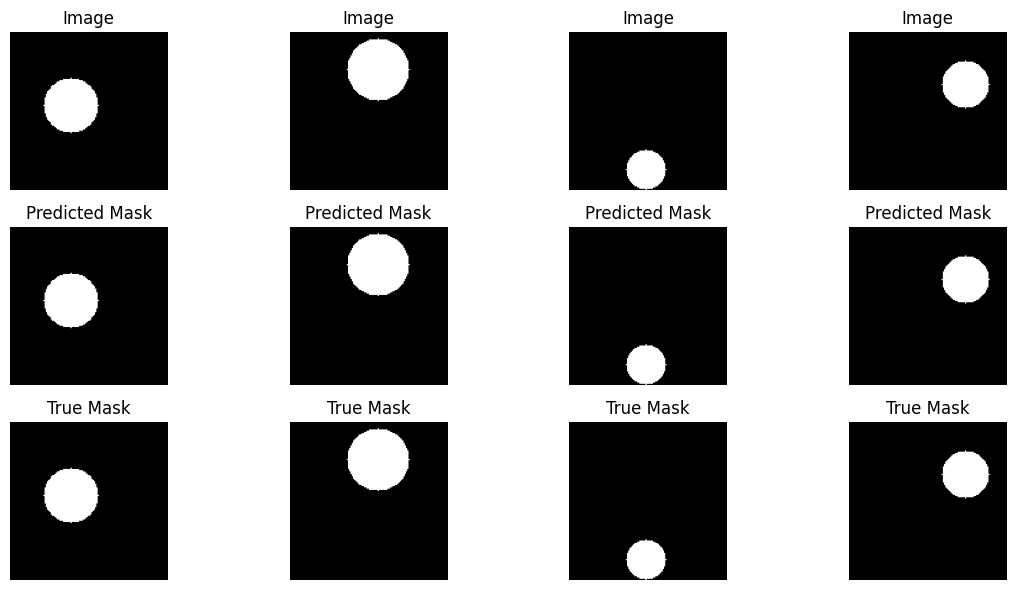

In [6]:
model.eval()
with torch.no_grad():
    imgs, masks = next(iter(val_loader))
    imgs = imgs.to(device)
    masks = masks.to(device)
    logits = model(imgs)
    preds = torch.sigmoid(logits)
    preds_bin = (preds > 0.5).float()

plt.figure(figsize=(12, 6))
for i in range(4):  
    plt.subplot(3, 4, i+1)
    plt.imshow(imgs[i, 0].cpu().numpy(), cmap='gray')
    plt.title("Image")
    plt.axis('off')
    
    plt.subplot(3, 4, i+5)
    plt.imshow(preds_bin[i, 0].cpu().numpy(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')
    
    plt.subplot(3, 4, i+9)
    plt.imshow(masks[i, 0].cpu().numpy(), cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()